In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft
from glob import glob

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
ds = xr.Dataset(coords={'time': ('time', np.arange(3000)*3600.)})
ds = ds.assign(u=np.cos(2.*np.pi*2/86400.*ds.time)+np.random.randn(ds.time.size))
ds = ds.assign(v=np.sin(2.*np.pi*2/86400.*ds.time)+np.random.randn(ds.time.size))
print(ds)

<xarray.Dataset>
Dimensions:  (time: 3000)
Coordinates:
  * time     (time) float64 0.0 3.6e+03 7.2e+03 1.08e+04 1.44e+04 1.8e+04 ...
Data variables:
    u        (time) float64 1.729 1.076 1.813 -0.7771 -1.303 -0.9558 -2.233 ...
    v        (time) float64 1.719 0.9022 1.819 0.8962 1.073 1.086 0.08853 ...


In [15]:
file_out = '/home1/datawork/xyu/u_test.nc'
ds.to_netcdf(file_out, mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


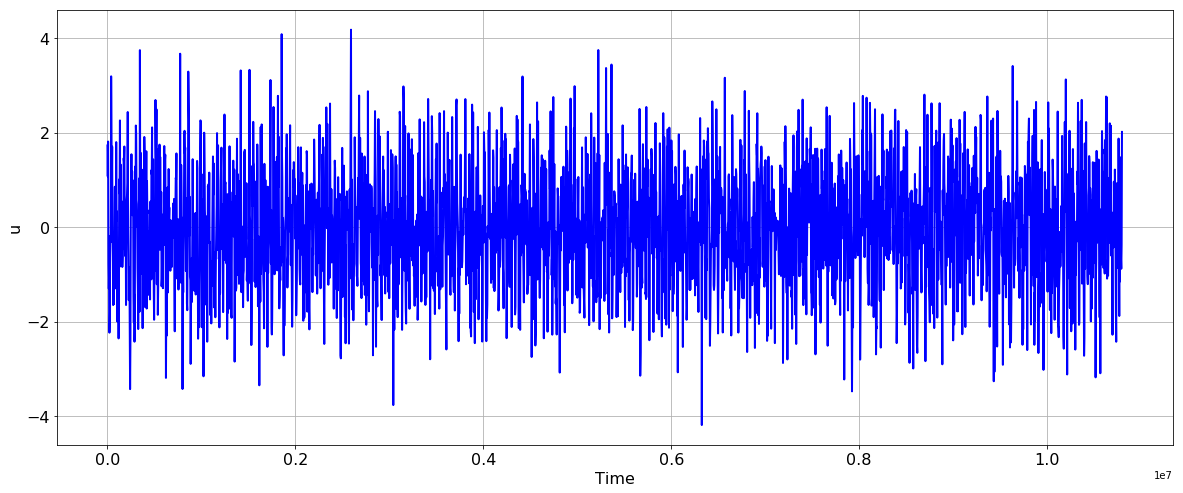

In [3]:
fig, ax = plt.subplots(figsize=(20,8))
ds['u'].plot(color='blue', linewidth=2.0)
ax.grid()
# Label, size
ax.set_xlabel('Time',fontsize=16)
ax.set_ylabel('u',fontsize=16)
ax.tick_params(labelsize=16)


# 2. Normal FFT (i.e. one segment, no overlapping)

## 2.1 applying a hanning window

In [32]:
u_normal = ds['u']

u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, detrend=None, window=True)
E_u_normal_w = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)/3000*3600
print(E_u_normal_w)
E_u_normal_w = np.real(E_u_normal_w).rename('u_power_spectrum')

<xarray.DataArray (freq_time: 3000)>
array([525.508712+0.j, 605.763614+0.j, 317.324693+0.j, ..., 196.773827+0.j,
       317.324693+0.j, 605.763614+0.j])
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08


In [33]:
# diff_f
df=E_u_normal_w.freq_time[1]-E_u_normal_w.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(9.259259e-08)
Coordinates:
    freq_time_spacing  float64 9.259e-08


In [34]:
(E_u_normal_w*df).sum(dim='freq_time').compute() ############

<xarray.DataArray ()>
array(0.530401)
Coordinates:
    freq_time_spacing  float64 9.259e-08

In [28]:
E_u_normal_w_segments = xrft.power_spectrum(u_normal.fillna(0.), window=True, detrend='constant')
E_u_normal_w_segments 

<xarray.DataArray (freq_time: 3000)>
array([ 49.274973, 874.866744,  90.994369, ..., 158.555367,  90.994369,
       874.866744])
Coordinates:
  * freq_time          (freq_time) float64 -0.0001389 -0.0001388 -0.0001387 ...
    freq_time_spacing  float64 9.259e-08

In [8]:
df=E_u_normal_w_segments.freq_time[1]-E_u_normal_w_segments.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(9.259259e-08)
Coordinates:
    freq_time_spacing  float64 9.259e-08


In [9]:
(E_u_normal_w_segments*df).sum(dim='freq_time').compute() ############

<xarray.DataArray ()>
array(0.530323)
Coordinates:
    freq_time_spacing  float64 9.259e-08

In [21]:
E_u_normal_w = E_u_normal_w.assign_coords(freq_time=E_u_normal_w.freq_time * 86400.) 
E_u_normal_w

<xarray.DataArray 'u_power_spectrum' (freq_time: 3000)>
array([218.860975, 341.913749, 317.211237, ..., 196.747735, 317.211237,
       341.913749])
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.008 0.016 0.024 0.032 0.04 ...
    freq_time_spacing  float64 9.259e-08
    freq_cpd           (freq_time) float64 0.0 0.008 0.016 0.024 0.032 0.04 ...

(0.001, 20.0)

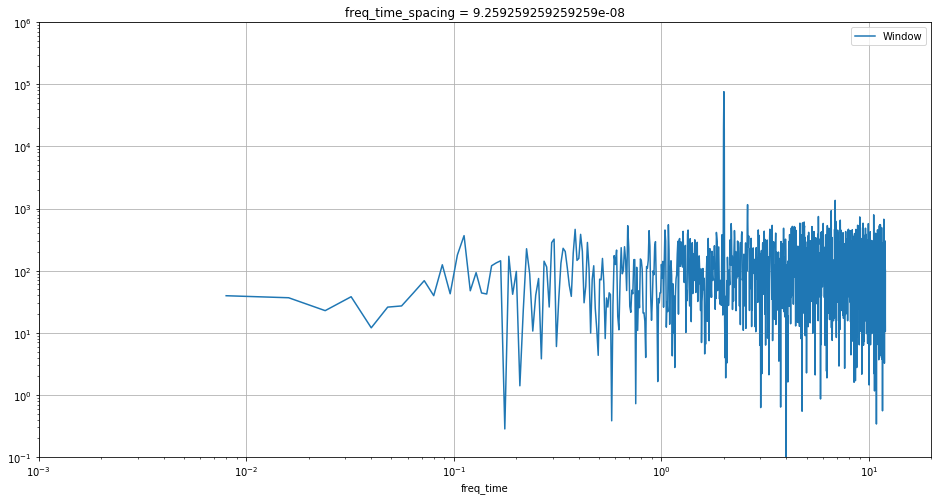

In [27]:
fig, ax = plt.subplots(figsize=(16,8))

labels = ['Window', 'No-window']

(E_u_normal_w/8.64).where(E_u_normal_w.freq_time>0).plot(ax=ax,label=labels[0])
#E_u_normal_w_segments.where(E_u_normal_w_segments.freq_time>0).plot(ax=ax, label=labels[1])

ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

#ax.set_xlim([8*1e-8,2*1e-4])
ax.set_ylim([1e-1,1e6])
ax.set_xlim([1e-3,2*1e1])

## the variance of the 'windowed' u

In [11]:
nfft = 3000  # 24hours * 60 = 60 days 
window = np.hanning(nfft)

In [12]:
u_normal_w = u_normal*window

In [13]:
np.var(u_normal_w)

<xarray.DataArray 'u' ()>
array(0.530352)

In [14]:
np.mean(u_normal_w*u_normal_w) 

<xarray.DataArray 'u' ()>
array(0.530401)

## 2.2 not applying a hanning window

In [11]:
u_normal = ds['u']

u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, detrend='linear', window=False)
#u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, window=False)
E_u_normal = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)/3000*3600
print(E_u_normal)
E_u_normal = np.real(E_u_normal).rename('u_power_spectrum')

<xarray.DataArray (freq_time: 3000)>
array([6.679443e-27+0.j, 1.705927e+03+0.j, 2.576330e+03+0.j, ...,
       6.238309e+03+0.j, 2.576330e+03+0.j, 1.705927e+03+0.j])
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08


In [12]:
# diff_f
df=E_u_normal.freq_time[1]-E_u_normal.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(9.259259e-08)
Coordinates:
    freq_time_spacing  float64 9.259e-08


In [13]:
(E_u_normal*df).sum(dim='freq_time').compute()

<xarray.DataArray ()>
array(1.521268)
Coordinates:
    freq_time_spacing  float64 9.259e-08

## The variance of u (should be approximately equal to the mean energy, u^2)

In [14]:
# the variance of u 
np.var(ds['u'])

<xarray.DataArray 'u' ()>
array(1.521692)

In [15]:
# the time-mean of u
np.mean(ds['u']) 

<xarray.DataArray 'u' ()>
array(-0.027844)

In [16]:
# mean-energy in time domain
np.mean(ds['u']*ds['u']) 

<xarray.DataArray 'u' ()>
array(1.522468)

## 2.3 Comparison

(1.0, 10000000.0)

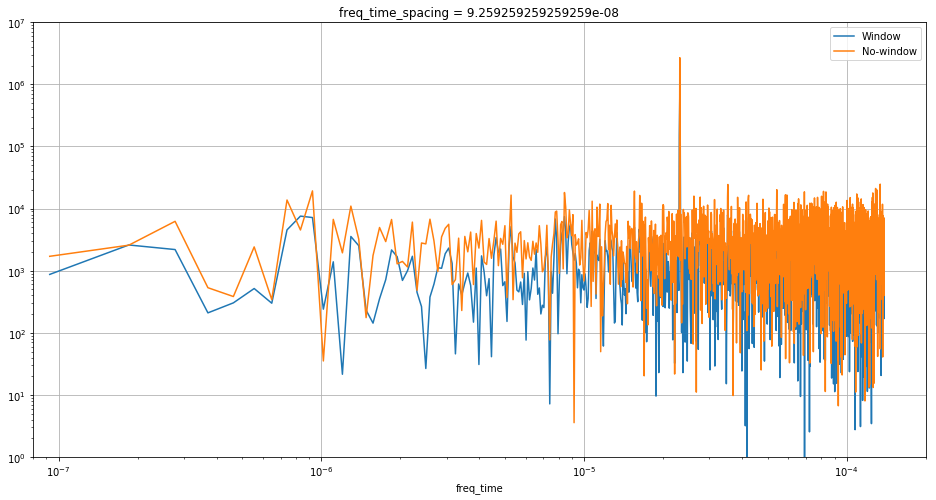

In [17]:
fig, ax = plt.subplots(figsize=(16,8))

labels = ['Window', 'No-window']

E_u_normal_w.where(E_u_normal_w.freq_time>0).plot(ax=ax, label=labels[0])
E_u_normal.where(E_u_normal.freq_time>0).plot(ax=ax, label=labels[1])

ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([8*1e-8,2*1e-4])
ax.set_ylim([1e0,1e7])

______

# 3.FFT with segments (50% overlap windows)

In [18]:
E_dir = '/home1/scratch/xyu/mit_spec/E_u_1d/'

nfft = 500
noverlap = nfft/2

T = np.arange(0, len(ds['u'].time)-int(nfft/2), int(nfft/2))
print(T)

for t in T:
    
    u = ds['u'].isel(time=slice(t,t+nfft))   
    u_fft = xrft.dft(u.fillna(0.), shift=False, detrend='linear', window=False)    
    #u_fft = xrft.dft(u.fillna(0.), shift=False, window=False)    

    E_u = (u_fft*u_fft.conj()).where(u_fft!=0., drop=False)/nfft*3600    
    
    #E_u = E_u.astype('f8').rename('E_u')
    E_u = np.real(E_u).rename('E_u')
    #file_E = E_dir+'E_u_t%04d_tt%03d.nc'%t,t 
    file_E = E_dir+'E_u_t{1:.0f}_t{1:.0f}.nc'.format(t,t)     
    E_u.to_netcdf(file_E, mode='w')  

[   0  250  500  750 1000 1250 1500 1750 2000 2250 2500]


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6

In [19]:
filenames = sorted(glob(E_dir+'E_u_t*.nc'))
%time ds0 = xr.open_mfdataset(filenames, concat_dim='blocks', compat='equals')
print(ds0)

CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 46.3 ms
<xarray.Dataset>
Dimensions:            (blocks: 11, freq_time: 500)
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.556e-07 1.111e-06 1.667e-06 ...
    freq_time_spacing  float64 5.556e-07
Dimensions without coordinates: blocks
Data variables:
    E_u                (blocks, freq_time) float64 dask.array<shape=(11, 500), chunksize=(1, 500)>


In [20]:
E = (ds0.E_u).mean(dim='blocks')
print(E)

<xarray.DataArray 'E_u' (freq_time: 500)>
dask.array<shape=(500,), dtype=float64, chunksize=(500,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.556e-07 1.111e-06 1.667e-06 ...
    freq_time_spacing  float64 5.556e-07


In [21]:
df=E.freq_time[1]-E.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(5.555556e-07)
Coordinates:
    freq_time_spacing  float64 5.556e-07


In [22]:
(E*df).sum(dim='freq_time').compute()

<xarray.DataArray ()>
array(1.510446)
Coordinates:
    freq_time_spacing  float64 5.556e-07

# 4. Comparison

(1.0, 10000000.0)

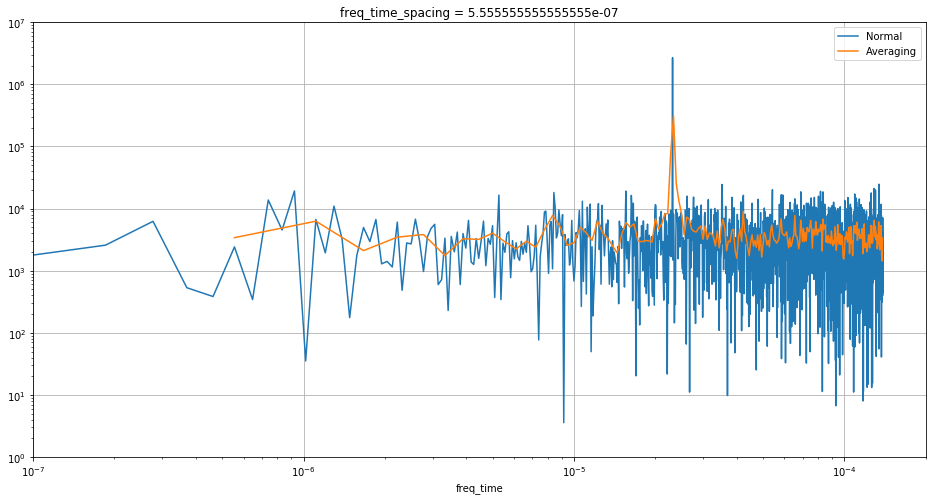

In [23]:
fig, ax = plt.subplots(figsize=(16,8))

labels = ['Normal', 'Averaging']

E_u_normal.where(E_u_normal.freq_time>0).plot(ax=ax, label=labels[0])
E.where(E.freq_time>0).plot(ax=ax, label=labels[1])
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([1e-7,2*1e-4])
ax.set_ylim([1e0,1e7])

# Others

In [8]:
df = 1/3600/3000
print(df)

1.8518518518518518e-07


In [13]:
ds.time.size

3000

In [14]:
u = ds['u'].values

In [15]:
fu = np.fft.fftn(u)

In [16]:
np.mean(u**2)

1.5465618038800284

In [17]:
np.sum(abs(fu)**2)/u.size**2/df*df

1.5465618038800284

In [19]:
np.sum(abs(fu)**2)/u.size**2/df*df

1.5465618038800284